# **Sprint 11**

Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios llegan a la etapa de compra. ¿Cuántos usuarios realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B. Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

# Paso 1
-  Abrir el archivo de datos y leer la información general


In [1]:
#Importar librerías

import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt
pd.options.mode.chained_assignment = None
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

#importar dataset
df_en_bruto = pd.read_csv('/content/logs_exp_us.csv',sep='\t')

# Paso 2
(Análisis exploratorio del dataset)

- Cambia el nombre de las columnas de manera que sea conveniente para ti.
- Comprueba los tipos de datos y valores ausentes. Corrige los datos si es necesario.
- Agrega una columna de fecha y hora y una columna separada para las fechas.

In [2]:
df_en_bruto.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
df_en_bruto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Se encuentra un DataFrame de 4 columnas, con 24126 filas. La información que contiene corresponde a cada entrada de registro es una acción de usuario o un evento y está acorde a la esperada según el diccionario de datos:

- EventName: nombre del evento. (string)
- DeviceIDHash: identificador de usuario unívoco. (int)
- EventTimestamp: hora del evento. (int)
- ExpId: número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba. (int)

Los nombres de las columnas se encuentran en un formato mixto (altas y bajas). Antes de seguir con la exploración de los datos se procede al cambio de los nombres de las columnas en un formato adecuado.

También, es importante mencionar que al importar el dataset nos encontramos que el archivo no venía separado por comas si no por una diagonal invertida (\), por lo que se añadió el  parametro "sep= '\t'" al llamado del DataFrame.  

Como una irregularidad, se encuentra que aunque se registró la hora de ocurrencia del evento en la columna EventTimestamp, se encuentra en un formato distinto al que se usa convencionalmente para las horas, esto quiere decir que los datos de la columna registraron la hora en segundos, milisegundos o minutos.

Los datos de la columna EventName también se encuentran en altas y bajas, respetando la integridad de los datos se dejarán así ya que no compromete los resultados de la investigación, por el momento.


In [4]:
#cambio de formato nombres de columnas
new_names_col=[]
for i in df_en_bruto.columns:
  names_lowered= i.lower()
  new_names_col.append(names_lowered)

df_en_bruto.columns=new_names_col

df_en_bruto.head()

,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
df_en_bruto.isna().sum() #Búsqueda de valores nulos en toda la tabla

,0
eventname,0
deviceidhash,0
eventtimestamp,0
expid,0


In [6]:
df_en_bruto['deviceidhash'].value_counts().sort_index() #Búsqueda de valores nulos o anomalías en el id de usuario

,count
deviceidhash,
6888746892508752,1
6909561520679493,5
6922444491712477,47
7435777799948366,6
7702139951469979,137
...,...
9217594193087726423,9
9219463515465815368,17
9220879493065341500,7


In [7]:
df_en_bruto['eventname'].value_counts() #busqueda de valores núlos o anomalías en la columna eventname

,count
eventname,
MainScreenAppear,119205
OffersScreenAppear,46825
CartScreenAppear,42731
PaymentScreenSuccessful,34313
Tutorial,1052


In [8]:
df_en_bruto['expid'].value_counts() # Búsqueda de valores nulos o anomalías en la columna expid

,count
expid,
248,85747
246,80304
247,78075


In [9]:
df_en_bruto['eventtimestamp'].value_counts().sort_index()  #Búsqueda de valores nulos o anomalías en la columna eventtimestamp

,count
eventtimestamp,
1564029816,1
1564053102,1
1564054127,2
1564055322,1
1564055323,1
...,...
1565212345,1
1565212439,1
1565212483,1


Aunque desde el comienzo se hacen verificaciones para encontrar valores ausentes, se reconfirma con el método .isna().sum() y no es encuentran valores ausentes en el DataFrame.

Además, en búsqueda de valores ausentes o errores en los datos se revisa cada columna por separado para observar la integridad de los datos. A parte del formato anormal del registro del evento no se encuentran valores ausentes extraños, es decir, omisiones en el registro de la información tanto implícita, como explícitamente.

In [10]:
df_en_bruto['eventtimestamp_dt']=pd.to_datetime(df_en_bruto['eventtimestamp'], unit='s')
df_en_bruto.head()

,eventname,deviceidhash,eventtimestamp,expid,eventtimestamp_dt
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


**Conclusiones paso 2**

Se encuentra un dataframe completo, que coincide con los valores esperados en cuanto a columnas y contenido. No hay valores nulos o ausentes. Se realizó el cambio de nombre de columnas, originalmente mezclaba mayúsculas y minúsculas y ahora solo tiene minúsculas. También se agregó la columna eventtimestampdt que contiene la fecha y hora de registro del evento en formato to_datetime. Como observación se encuentra que la fecha y hora del evento se está registrando en segundos, sería util que se agregara en la información del diccionario de datos.

Así obtenemos un Data Frame de 5 columnas y 244126 filas.

# Paso 3
(Análisis exploratorio de los datos)
-  ¿Cuántos eventos hay en los registros?
-  ¿Cuántos usuarios hay en los registros?
-  ¿Cuál es el promedio de eventos por usuario?
-  ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. -  Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?
-  ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?
-  Asegúrate de tener usuarios de los tres grupos experimentales.

Algunos de estos puntos se respondieron previamente en el paso 2 con la exploración de datos y la búsqueda de valores ausentes, sin embargo se vuelve a desarrollar el código aquí para facilitar el análisis y evaluación del presente proyecto.

In [11]:
#1. ¿Cuántos eventos hay en los registros?
numero_de_eventos = len(df_en_bruto['eventname'].value_counts())
#2. ¿Cuántos usuarios hay en los registros?
numero_de_usuarios = df_en_bruto['deviceidhash'].nunique()

print('El número de eventos en los registros es:', numero_de_eventos, 'y el número de usuarios es:', numero_de_usuarios)

El número de eventos en los registros es: 5 y el número de usuarios es: 7551


In [12]:
#3. ¿Cuál es el promedio de eventos por usuario?
pedidos_x_usuario= df_en_bruto.groupby('deviceidhash')['eventname'].count().reset_index() #Dataframe para filtrar los datos por usuario y contar el número de eventos registrados bajo su id
pedidos_promedio_x_usuario = pedidos_x_usuario['eventname'].mean() #Cálculo general del promedio de eventos por usuario
print(pedidos_x_usuario)
print('El promedio de eventos por usuario es:',pedidos_promedio_x_usuario)

             deviceidhash  eventname
0        6888746892508752          1
1        6909561520679493          5
2        6922444491712477         47
3        7435777799948366          6
4        7702139951469979        137
...                   ...        ...
7546  9217594193087726423          9
7547  9219463515465815368         17
7548  9220879493065341500          7
7549  9221926045299980007          7
7550  9222603179720523844         59

[7551 rows x 2 columns]
El promedio de eventos por usuario es: 32.33028737915508


La fecha máxima es: 2019-08-07 21:15:17
La fecha mínima es: 2019-07-25 04:43:36
Esto quiere decir que el rango de fechas es de casi dos semanas




Text(0.5, 1.0, 'Histograma de distribución de hora y fecha de registro de eventos')

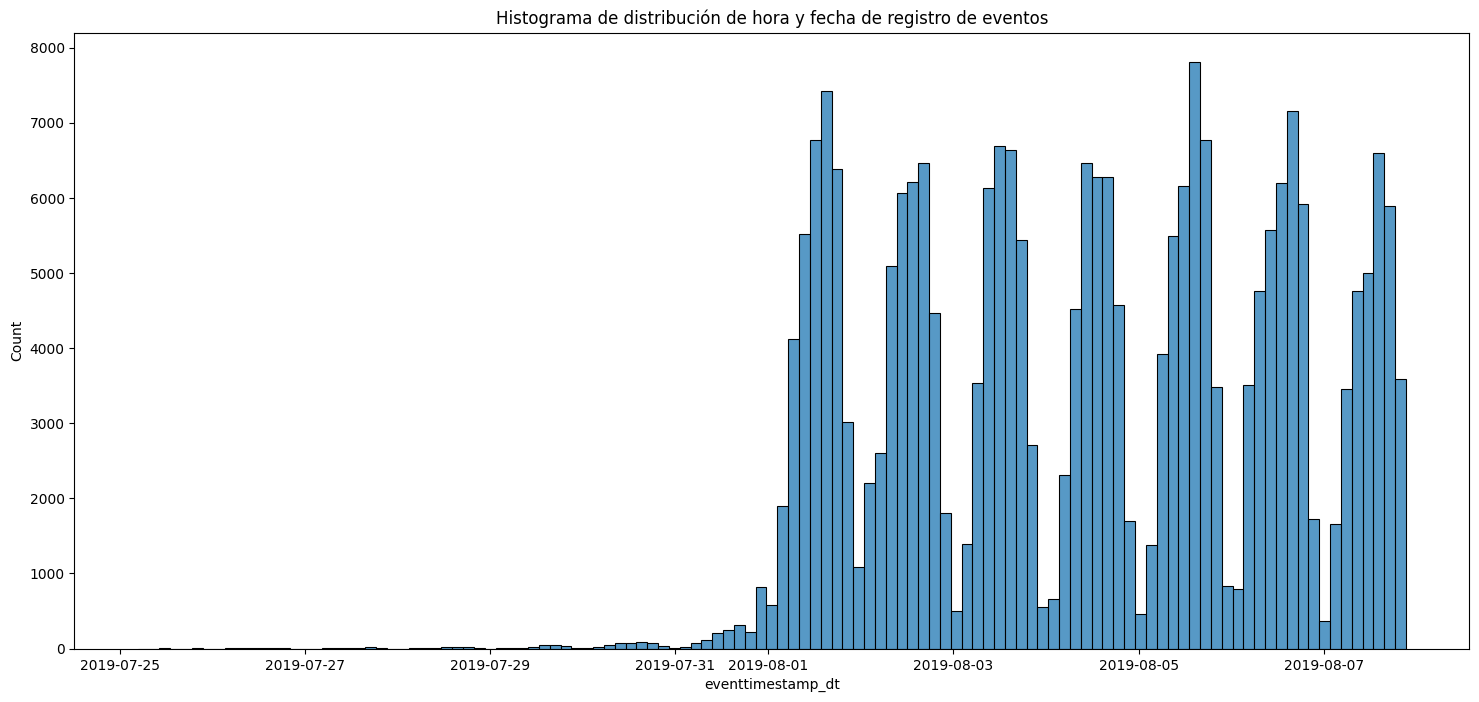

In [13]:
#4.¿Qué periodo de tiempo cubren los datos?
 #Encuentra la fecha máxima y mínima.
fecha_minima = df_en_bruto['eventtimestamp_dt'].min()
fecha_maxima = df_en_bruto['eventtimestamp_dt'].max()

print('La fecha máxima es:', fecha_maxima)
print('La fecha mínima es:', fecha_minima)
print('Esto quiere decir que el rango de fechas es de casi dos semanas')
print('\n')
 #Traza un histograma por fecha y hora
plt.figure(figsize=(18,8))
sns.histplot(df_en_bruto['eventtimestamp_dt'])
plt.title('Histograma de distribución de hora y fecha de registro de eventos')

 **¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior.**

Al revisar el histograma vemos una distribución sesgada a la derecha, lo que nos indica que al comienzo del experimento no se registraron los suficientes datos o que hubo un error en la recolección de la información. No se tienen dato para abarcar todo el periodo de prueba (2 semanas). El momento en el que se encuentran datos significativos es el 2019-08-01, se filtrará todo el Data Frame a una semana comprendida entre el 2019-08-01 y el 2019-08-07 atendiendo la sugerencia del ejercicio.

In [14]:
#Filtro de fecha

df_filtrado = df_en_bruto[df_en_bruto['eventtimestamp_dt'] >= '2019-08-01'].reset_index(drop=True)
df_filtrado

,eventname,deviceidhash,eventtimestamp,expid,eventtimestamp_dt
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55
3,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58
4,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59
...,...,...,...,...,...
241293,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25
241294,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59
241295,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43
241296,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58


La fecha máxima es: 2019-08-07 21:15:17
La fecha mínima es: 2019-08-01 00:07:28
Esto quiere decir que el rango de fechas es de casi dos semanas




Text(0.5, 1.0, 'Histograma de distribución de hora y fecha de registro de eventos, con filtro')

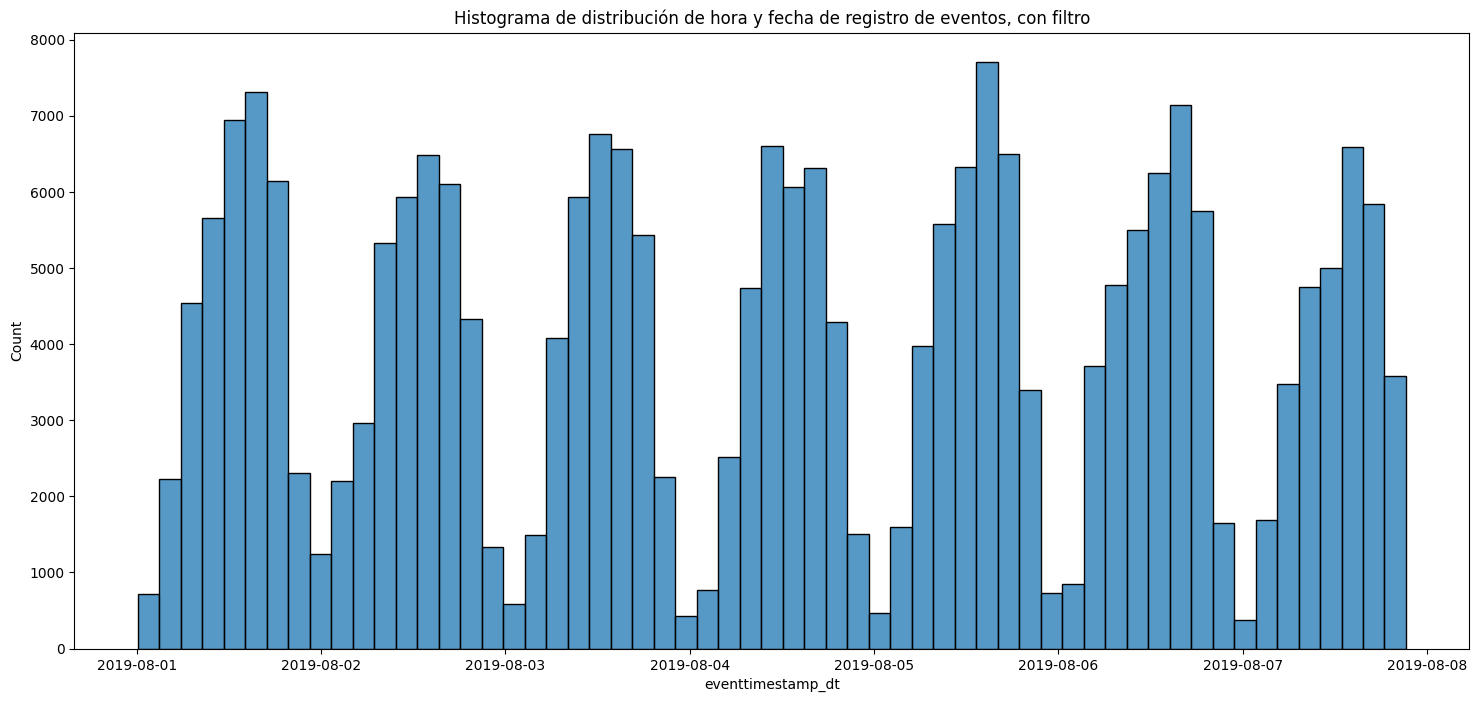

In [15]:
 #Corroboración del filtro.
fecha_minima_filtrada = df_filtrado['eventtimestamp_dt'].min()
fecha_maxima_filtrada = df_filtrado['eventtimestamp_dt'].max()

print('La fecha máxima es:', fecha_maxima_filtrada)
print('La fecha mínima es:', fecha_minima_filtrada)
print('Esto quiere decir que el rango de fechas es de casi dos semanas')
print('\n')
 #Traza un histograma por fecha y hora
plt.figure(figsize=(18,8))
sns.histplot(df_filtrado['eventtimestamp_dt'])
plt.title('Histograma de distribución de hora y fecha de registro de eventos, con filtro')

In [16]:
#5. ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?
numero_de_usuarios_filtrados = df_filtrado['deviceidhash'].nunique() #Conteo de usuarios después de realizar el filtro
print('Número de usuarios original:', numero_de_usuarios, 'Numero de usuarios con el filtro de fecha:', numero_de_usuarios_filtrados)


Número de usuarios original: 7551 Numero de usuarios con el filtro de fecha: 7534


**¿Qué periodo representan realmente los datos?
¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?**

Definitivamente el periodo fuerte de datos se encuentra en la primera semana de agosto, solo se perdieron 3.000 filas y solo se perdieron 17 usuarios. La integridad de la información de la prueba no se comprometió radicalmente con el filtro de la fecha basado en el periodo de representación estadística. Igualmente se repitió el procedimiento para encontrar el periodo que representa los datos con el DataFrame filtrado para verificar el funcionamiento del filtro y la calidad del intervalo de tiempo en cuanto a representación estadística.

In [17]:
#6. Asegúrate de tener usuarios de los tres grupos experimentales.
df_filtrado.groupby('expid')['deviceidhash'].nunique()

,deviceidhash
expid,
246,2484
247,2513
248,2537


In [18]:
df_filtrado['deviceidhash'].nunique()

7534

Se finaliza el análisis exploratorio de los datos. Se encuentra que hay una diferencia entre el número de usuarios que componen la prueba. También se encuentra que aunque la recolección de datos duró 2 semanas, en realidad solo hay datos representativos para una semana que comprende entre 1 y el 7 de agosto de 2019. Por lo anterior se realizpo un filtro para solo tener los datos de este rango de fechas.

Se comprobó que la integridad de los datos no se viera comprometida al realizar el filtro, por lo que ahora el Data Frame se compone de 5 columnas, 241298 filas, las fechas de estudio van desde 2019-08-01 hasta 2019-08-07.

# Paso 4. Estudiar el embudo de eventos

- Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.
- Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios. Calcula la proporción de usuarios que realizaron la acción al menos una vez.
- ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.
Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.
- ¿En qué etapa pierdes más usuarios?
- ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

In [19]:
#1. Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.
frecuencia_eventos= df_filtrado['eventname'].value_counts().sort_values(ascending=False)
frecuencia_eventos

,count
eventname,
MainScreenAppear,117431
OffersScreenAppear,46350
CartScreenAppear,42365
PaymentScreenSuccessful,34113
Tutorial,1039


In [20]:
2. #Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios.
usuarios_vs_accion= df_filtrado.groupby('eventname').agg({'deviceidhash':'nunique'}).sort_values(by='deviceidhash',ascending=False)
usuarios_vs_accion

,deviceidhash
eventname,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [21]:
# Calcula la proporción de usuarios que realizaron la acción al menos una vez.
usuarios_vs_accion['proporcion']= usuarios_vs_accion['deviceidhash']/7534
usuarios_vs_accion

,deviceidhash,proporcion
eventname,,
MainScreenAppear,7419,0.984736
OffersScreenAppear,4593,0.609636
CartScreenAppear,3734,0.495620
PaymentScreenSuccessful,3539,0.469737
Tutorial,840,0.111495


**#3**

<h3>¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo. Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.<h3>

La secuencia de eventos es: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful y Tutorial. Además, todas parecen tener una conexión lógica lo que hace entender que hacen parte de la misma secuencia, salvo por Tutorial. No tiene sentido que las personas realicen un Tutorial al final, así que hay dos opciones: 1. El tuturial están en un lugar intermedio de la página o 2. El tutorial está al final de la página, sin importar la opción lo que se puede concluir es que muy pocas personas ven el tutorial. Si la información que aloja el tutorial es muy importante, quizá eso tiene que ver con que solo el 47% de las personas logren realizar su compra. Aunque ese porcentaje no es para nada despreciable.

Etapa|eventname	| número de usuarios | porcentaje
---|---|---|---|
Etapa A| MainScreenAppear |	7419|	98%
Etapa B| OffersScreenAppear	|4593	|60%
Etapa C|CartScreenAppear	|3734	|49%
Etapa D|PaymentScreenSuccessful|	3539|	46%
Etapa E| Tutorial|	840	| 11%

**#4** ¿En qué etapa pierdes más usuarios?

Se pierden más usuarios en la etapa Tutorial (Etapa E), es decir 6.694 o el 89% de la población.

**#5**¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

El 46%, o sea 3539.

#Paso 5 Estudiar los resultados del experimento

- ¿Cuántos usuarios hay en cada grupo?

- Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.
- Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?
- Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?
- ¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significancia? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.


In [22]:
1. #¿Cuántos usuarios hay en cada grupo?
usuarios_x_grupo = df_filtrado.groupby('expid')['deviceidhash'].nunique()
usuarios_x_grupo

,deviceidhash
expid,
246,2484
247,2513
248,2537


In [23]:
#2.Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos.
 #Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

grupo_a1= df_filtrado[df_filtrado['expid']== 246] #filtro  Dataframe por grupo de usuarios del grupo A1
grupo_a2= df_filtrado[df_filtrado['expid']== 247] #filtro  Dataframe por grupo de usuarios del grupo A2
grupo_b= df_filtrado[df_filtrado['expid']== 248] #filtro  Dataframe por grupo de usuarios del grupo B

usuarios_grupo_a1 = grupo_a1['deviceidhash'].unique() #conteo de usuarios para el grupo A1
usuarios_grupo_a2 = grupo_a2['deviceidhash'].unique() #conteo de usuarios para el grupo A2
prueba= st.ttest_ind(usuarios_grupo_a1,usuarios_grupo_a2) #Aplicación de prueba de comparación de poblaciones para las muestras de los grupos de control.
alpha= 0.05
print(prueba.pvalue)

if prueba.pvalue < alpha:
  print('Hay diferencias estadísticamente significativas entre las poblaciones de las muestras de los grupos de control.')
else:
  print('No hay diferencias estadísticamente significativas entre las poblaciones de las muestras de los grupos de control.')

0.697888199211046
No hay diferencias estadísticamente significativas entre las poblaciones de las muestras de los grupos de control.


In [24]:
#3. Selecciona el evento más popular.
 #En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción.

usuarios_evento_grupoa_1 = grupo_a1[grupo_a1['eventname']=='MainScreenAppear']['deviceidhash'].nunique() #filtro evento más popular ''MainScreenAppear'  y conteo de usuarios que hicieron ese evento para el grupo A1
usuarios_evento_grupoa_2 = grupo_a2[grupo_a2['eventname']=='MainScreenAppear']['deviceidhash'].nunique() #filtro evento más popular ''MainScreenAppear'  y conteo de usuarios que hicieron ese evento para el grupo A2

print('Cantidad de personas que visitaron la página en el grupo A1:',usuarios_evento_grupoa_1, 'La proporción es:', usuarios_evento_grupoa_1/2484)
print('Cantidad de personas que visitaron la página en el grupo A2:',usuarios_evento_grupoa_2, 'La proporción es:', usuarios_evento_grupoa_2/2513)

Cantidad de personas que visitaron la página en el grupo A1: 2450 La proporción es: 0.9863123993558777
Cantidad de personas que visitaron la página en el grupo A2: 2476 La proporción es: 0.9852765618782332


In [25]:
#Comprueba si la diferencia entre los grupos es estadísticamente significativa.
    #¿Se refiere a la diferencia entre promedios de conversión?

exitos_main_event = [usuarios_evento_grupoa_1,usuarios_evento_grupoa_2] #creación de lista de usuarios de MainScreenAppear tanto para el grupo A como para el grupo A/A
total_usuarios_g_a_aa = [2484,2513] #creación de lista de total de usuarios grupo A y grupo A/A

prueba_1 = proportions_ztest(exitos_main_event, total_usuarios_g_a_aa) #Prueba de comparación de las proporciones de los dos grupos

print('Valor p:',prueba_1[1]) #Impresión valor p

if prueba_1[1] < alpha: #Comprobación de hipótesis
  print('Hay diferencias estadísticamente significativas entre las proporciones de usuarios que pasan por la pantalla principal en los grupos de control.')
else:
  print('No hay diferencias estadísticamente significativas entre las proporciones de usuarios que pasan por la pantalla principal en los grupos de control.')


Valor p: 0.7570597232046099
No hay diferencias estadísticamente significativas entre las proporciones de usuarios que pasan por la pantalla principal en los grupos de control.


In [26]:
#Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba).

def embudoexp (Dataframe): #Creación de función para hacer la prueba con todos los eventos

  #creación de filtro de grupo de experimento en el dataframe para la función
  grupoa1 = Dataframe.query('expid == 246')
  grupoa2 = Dataframe.query('expid == 247')

  #Conteo total de usuarios por grupo
  total_users_a1 = Dataframe.query('expid == 246')['deviceidhash'].nunique()
  total_users_a2 = Dataframe.query('expid == 247')['deviceidhash'].nunique()

  #conteo total de usuarios por evento
  users_x_event_a1= grupoa1.groupby('eventname')['deviceidhash'].nunique().reset_index()
  users_x_event_a2= grupoa2.groupby('eventname')['deviceidhash'].nunique().reset_index()

  #cambio de combre de columnas al los DF de conteo total de usuarios por evento
  users_x_event_a1.columns=['eventname','n°_users']
  users_x_event_a2.columns=['eventname','n°_users']

  #Agregar columna de proporción
  users_x_event_a1['proportion_a1'] = users_x_event_a1['n°_users'] / total_users_a1 *100
  users_x_event_a2['proportion_a2'] = users_x_event_a2['n°_users'] / total_users_a2 *100

  #Organizar valores
  users_x_event_a1 = users_x_event_a1.sort_values(by='n°_users',ascending= False)
  users_x_event_a2 = users_x_event_a2.sort_values(by='n°_users',ascending= False)


  return users_x_event_a1.merge(users_x_event_a2, on='eventname', suffixes=['_A1','_A2'])

print('Grupo A1 vs Grupo A2:')
embudoexp(df_filtrado)



Grupo A1 vs Grupo A2:


,eventname,n°_users_A1,proportion_a1,n°_users_A2,proportion_a2
0,MainScreenAppear,2450,98.631240,2476,98.527656
1,OffersScreenAppear,1542,62.077295,1520,60.485476
2,CartScreenAppear,1266,50.966184,1238,49.263828
3,PaymentScreenSuccessful,1200,48.309179,1158,46.080382
4,Tutorial,278,11.191626,283,11.261441


In [28]:
#hacer prueba de significancia

embudo_unificado_grupo_aa = embudoexp(df_filtrado) #Declaración de Data Frame

def prueba_sig (Dataframe):

  #Conteo total de usuarios por grupo
  total_users_a = 2484
  total_users_aa = 2513
  total_users= [total_users_a,total_users_aa] #Creación de lista con el total de usuarios del grupo A y el grupo A/A
  pvalor = {} #Diccionario vació para realizar posteriormente DataFrame
  for row in Dataframe: #Bucle for para iterar sobre el evento
    if Dataframe.iloc[0,1] and Dataframe.iloc[0,3]: #Condición de filtrado, seleccionado solo los valores del DF que nos interesan
      MainScreenAppear_A= Dataframe.iloc[0,1] #Selección de datos del evento a para el grupo A
      MainScreenAppear_AA= Dataframe.iloc[0,3] #Selección de datos del evento a para el grupo A/A
      prueba0 = proportions_ztest([MainScreenAppear_A, MainScreenAppear_AA],total_users) #Realización de prueba de comparación de proporciones
      pvalor['MainScreenAppear']= "{:.3f}".format(prueba0[1]) #Integra el resultado de la prueba al diccionario vacío, creado previamente
#Se repite el procedimiento anterior para los demás eventos
  for row in Dataframe:
    if Dataframe.iloc[1,1] and Dataframe.iloc[1,3]:
      OffersScreenAppear_A= Dataframe.iloc[1,1]
      OffersScreenAppear_AA= Dataframe.iloc[1,3]
      prueba01 = proportions_ztest([OffersScreenAppear_A, OffersScreenAppear_AA],total_users)
      pvalor['OffersScreenAppear']= "{:.3f}".format(prueba01[1])
  for row in Dataframe:
    if Dataframe.iloc[2,1] and Dataframe.iloc[2,3]:
      CartScreenAppear_A= Dataframe.iloc[2,1]
      CartScreenAppear_AA= Dataframe.iloc[2,3]
      prueba2 = proportions_ztest([CartScreenAppear_A, CartScreenAppear_AA], total_users)
      pvalor['CartScreenAppear']= "{:.3f}".format(prueba2[1])
  for row in Dataframe:
    if Dataframe.iloc[3,1] and Dataframe.iloc[3,3]:
      PaymentScreenSuccessful_A= Dataframe.iloc[3,1]
      PaymentScreenSuccessful_AA= Dataframe.iloc[3,3]
      prueba3 = proportions_ztest([PaymentScreenSuccessful_A, PaymentScreenSuccessful_AA], total_users)
      pvalor['PaymentScreenSuccessful']= "{:.3f}".format(prueba3[1])
  for row in Dataframe:
    if Dataframe.iloc[4,1] and Dataframe.iloc[4,3]:
      Tutotial_A= Dataframe.iloc[4,1]
      Tutorial_AA= Dataframe.iloc[4,3]
      prueba4 = proportions_ztest([Tutotial_A, Tutorial_AA],total_users)
      pvalor['Tutorial']= "{:.3f}".format(prueba4[1])

  return pd.DataFrame.from_dict(pvalor, orient= 'index', columns= ['pvalue']) #Devuelve un DF con los resultados de la prueba




prueba_sig(embudo_unificado_grupo_aa) #Muestra los resultados de la función

,pvalue
MainScreenAppear,0.757
OffersScreenAppear,0.248
CartScreenAppear,0.229
PaymentScreenSuccessful,0.115
Tutorial,0.938


In [29]:
df_a_aa= prueba_sig(embudo_unificado_grupo_aa).reset_index() #Declara el Dataframe con los resultados de la prueba de significación estadística para los grupos A/A
df_a_aa.columns= ['eventname','pvalue'] #Cambia los nombres de las columnas del dataframe para poder unirl los resultados de la prueba con el DataFrame de usuarios por evento
pruebas_a = embudo_unificado_grupo_aa.merge(df_a_aa, on='eventname') #unión del DataFrame de prueba de pvalor con el de usuarios por evento y por grupo A/A
pruebas_a

,eventname,n°_users_A1,proportion_a1,n°_users_A2,proportion_a2,pvalue
0,MainScreenAppear,2450,98.631240,2476,98.527656,0.757
1,OffersScreenAppear,1542,62.077295,1520,60.485476,0.248
2,CartScreenAppear,1266,50.966184,1238,49.263828,0.229
3,PaymentScreenSuccessful,1200,48.309179,1158,46.080382,0.115
4,Tutorial,278,11.191626,283,11.261441,0.938


In [30]:
pruebas_a['pvalue'] = pd.to_numeric(pruebas_a['pvalue']) #Convierte a un formato numérico la columna de value, que al resultar de la prueba terminaron como object

#Bucle for para iterar en cada fila en el valor p para determinar si se cumple o no la hipótesis nula.

for index, row in pruebas_a.iterrows():
  if row['pvalue'] < alpha:
    pruebas_a.loc[index, 'significancia'] = 'Hay diferencias.'
  else:
    pruebas_a.loc[index, 'significancia'] = 'No hay diferencias.'

display(pruebas_a)

,eventname,n°_users_A1,proportion_a1,n°_users_A2,proportion_a2,pvalue,significancia
0,MainScreenAppear,2450,98.631240,2476,98.527656,0.757,No hay diferencias.
1,OffersScreenAppear,1542,62.077295,1520,60.485476,0.248,No hay diferencias.
2,CartScreenAppear,1266,50.966184,1238,49.263828,0.229,No hay diferencias.
3,PaymentScreenSuccessful,1200,48.309179,1158,46.080382,0.115,No hay diferencias.
4,Tutorial,278,11.191626,283,11.261441,0.938,No hay diferencias.


**¿Puedes confirmar que los grupos se dividieron correctamente?**

Es correcto afirmar que los grupos se dividieron correctamente. Las diferencias entre usuarios son mínimas y estadísticamente la proporción de usuarios registrados en los grupo de control para cada evento es significativa.

In [31]:
#4 Haz lo mismo para el grupo con fuentes alteradas.
 #Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada.

def embudoexpcompleto (Dataframe): #Creación de función para hacer la prueba con todos los eventos

  #creación de filtro de grupo de experimento en el dataframe para la función
  grupoa1 = Dataframe.query('expid == 246')
  grupoa2 = Dataframe.query('expid == 247')
  grupob = Dataframe.query('expid == 248')

  #Conteo total de usuarios por grupo
  total_users_a1 = Dataframe.query('expid == 246')['deviceidhash'].nunique()
  total_users_a2 = Dataframe.query('expid == 247')['deviceidhash'].nunique()
  total_users_b = Dataframe.query('expid == 248')['deviceidhash'].nunique()

  #conteo total de usuarios por evento
  users_x_event_a1= grupoa1.groupby('eventname')['deviceidhash'].nunique().reset_index()
  users_x_event_a2= grupoa2.groupby('eventname')['deviceidhash'].nunique().reset_index()
  users_x_event_b= grupob.groupby('eventname')['deviceidhash'].nunique().reset_index()

  #cambio de combre de columnas al los DF de conteo total de usuarios por evento
  users_x_event_a1.columns=['eventname','n°_users']
  users_x_event_a2.columns=['eventname','n°_users']
  users_x_event_b.columns=['eventname','n°_users']

  #Agregar columna de proporción
  users_x_event_a1['proportion_a1'] = users_x_event_a1['n°_users'] / total_users_a1 *100
  users_x_event_a2['proportion_a2'] = users_x_event_a2['n°_users'] / total_users_a2 *100
  users_x_event_b['proportion_b'] = users_x_event_b['n°_users'] / total_users_b *100

  #Organizar valores
  users_x_event_a1 = users_x_event_a1.sort_values(by='n°_users',ascending= False)
  users_x_event_a2 = users_x_event_a2.sort_values(by='n°_users',ascending= False)
  users_x_event_b = users_x_event_b.sort_values(by='n°_users',ascending= False)

  df= users_x_event_a1.merge(users_x_event_a2, on='eventname', suffixes=['_A1','_A2'])
  return df.merge(users_x_event_b, on='eventname', suffixes = ['B']) #Devuelve un DF con los resultados de la prueba

print('Grupo A1 vs Grupo A2 vs Grupo B:')

usuarios_y_proporciones_total = embudoexpcompleto(df_filtrado)
usuarios_y_proporciones_total.columns=['eventname','usersa1','proportciona1', 'usersa2','proporciona2', 'usersb', 'proporcionb']
usuarios_y_proporciones_total

Grupo A1 vs Grupo A2 vs Grupo B:


,eventname,usersa1,proportciona1,usersa2,proporciona2,usersb,proporcionb
0,MainScreenAppear,2450,98.631240,2476,98.527656,2493,98.265668
1,OffersScreenAppear,1542,62.077295,1520,60.485476,1531,60.346866
2,CartScreenAppear,1266,50.966184,1238,49.263828,1230,48.482460
3,PaymentScreenSuccessful,1200,48.309179,1158,46.080382,1181,46.551045
4,Tutorial,278,11.191626,283,11.261441,279,10.997241


In [40]:
#hacer prueba de significancia grupo a/b

def prueba_grupo_ab (Dataframe):

  #Conteo total de usuarios por grupo
  total_users_a = 2484
  total_users_b = 2537
  total_users= [total_users_a,total_users_b] #Creación de lista con el total de usuarios del grupo A y el grupo B
  pvalor = {} #Diccionario vació para realizar posteriormente DataFrame
  for row in Dataframe: #Bucle for para iterar sobre el evento
    if Dataframe.iloc[0,5] and Dataframe.iloc[0,1]:  #Condición de filtrado, seleccionado solo los valores del DF que nos interesan
      MainScreenAppear_A= Dataframe.iloc[0,1] #Selección de datos del evento a para el grupo A
      MainScreenAppear_B= Dataframe.iloc[0,5] #Selección de datos del evento a para el grupo B
      prueba0 = proportions_ztest([MainScreenAppear_A, MainScreenAppear_B],total_users) #Realización de prueba de comparación de proporciones
      pvalor['MainScreenAppear']= "{:.3f}".format(prueba0[1])  #Integra el resultado de la prueba al diccionario vacío, creado previamente
#Se repite el procedimiento anterior para los demás eventos
  for row in Dataframe:
    if Dataframe.iloc[1,1] and Dataframe.iloc[1,5]:
      OffersScreenAppear_A= Dataframe.iloc[1,1]
      OffersScreenAppear_B= Dataframe.iloc[1,5]
      prueba1 = proportions_ztest([OffersScreenAppear_A, OffersScreenAppear_B],total_users)
      pvalor['OffersScreenAppear']= "{:.3f}".format(prueba1[1])
  for row in Dataframe:
    if Dataframe.iloc[2,1] and Dataframe.iloc[2,5]:
      CartScreenAppear_A= Dataframe.iloc[2,1]
      CartScreenAppear_B= Dataframe.iloc[2,5]
      prueba2 = proportions_ztest([CartScreenAppear_A, CartScreenAppear_B], total_users)
      pvalor['CartScreenAppear']= "{:.3f}".format(prueba2[1])
  for row in Dataframe:
    if Dataframe.iloc[3,1] and Dataframe.iloc[3,5]:
      PaymentScreenSuccessful_A= Dataframe.iloc[3,1]
      PaymentScreenSuccessful_B= Dataframe.iloc[3,5]
      prueba3 = proportions_ztest([PaymentScreenSuccessful_A, PaymentScreenSuccessful_B], total_users)
      pvalor['PaymentScreenSuccessful']= "{:.3f}".format(prueba3[1])
  for row in Dataframe:
    if Dataframe.iloc[4,1] and Dataframe.iloc[4,5]:
      Tutotial_A= Dataframe.iloc[4,1]
      Tutorial_B= Dataframe.iloc[4,5]
      prueba4 = proportions_ztest([Tutotial_A, Tutorial_B],total_users)
      pvalor['Tutorial']= "{:.3f}".format(prueba4[1])



  return pd.DataFrame.from_dict(pvalor, orient= 'index', columns= ['pvalue']) #Devuelve un DF con los resultados de la prueba


#organizar el Dataframe obtenido de la función
prueba_a_b = prueba_grupo_ab(usuarios_y_proporciones_total).reset_index()
prueba_a_b.columns=['eventname','pvalue_A/B']


prueba_a_b['pvalue_A/B'] = pd.to_numeric(prueba_a_b['pvalue_A/B']) #Convierte a un formato numérico la columna de value, que al resultar de la prueba terminaron como object

for col in prueba_a_b['pvalue_A/B']: #Bucle for para iterar en cada fila en el valor p para determinar si se cumple o no la hipótesis nula.
  if col < alpha:
    prueba_a_b['significancia_A/B'] = 'Hay diferencias.'
  else:
    prueba_a_b['significancia_A/B'] = 'No hay diferencias.'
print('Prueba de significancia estadística para los grupos A / B')
prueba_a_b

Prueba de significancia estadística para los grupos A / B


,eventname,pvalue_A/B,significancia_A/B
0,MainScreenAppear,0.295,No hay diferencias.
1,OffersScreenAppear,0.208,No hay diferencias.
2,CartScreenAppear,0.078,No hay diferencias.
3,PaymentScreenSuccessful,0.212,No hay diferencias.
4,Tutorial,0.826,No hay diferencias.


In [41]:
#hacer prueba de significancia grupo aa/b

def prueba_grupo_aab (Dataframe):

  #Conteo total de usuarios por grupo
  total_users_aa = 2513
  total_users_b = 2537
  total_users= [total_users_aa,total_users_b] #Creación de lista con el total de usuarios del grupo AA y el grupo B
  pvalor = {} #Diccionario vació para realizar posteriormente DataFrame
  for row in Dataframe:  #Bucle for para iterar sobre el evento
    if Dataframe.iloc[0,5] and Dataframe.iloc[0,3]:  #Condición de filtrado, seleccionado solo los valores del DF que nos interesan
      MainScreenAppear_AA= Dataframe.iloc[0,3] #Selección de datos del evento a para el grupo A/A
      MainScreenAppear_B= Dataframe.iloc[0,5] #Selección de datos del evento a para el grupo B
      prueba0 = proportions_ztest([MainScreenAppear_AA, MainScreenAppear_B],total_users) #Realización de prueba de comparación de proporciones
      pvalor['MainScreenAppear']= "{:.3f}".format(prueba0[1]) #Integra el resultado de la prueba al diccionario vacío, creado previamente
#Se repite el procedimiento anterior para los demás eventos
  for row in Dataframe:
    if Dataframe.iloc[1,3] and Dataframe.iloc[1,5]:
      OffersScreenAppear_AA= Dataframe.iloc[1,3]
      OffersScreenAppear_B= Dataframe.iloc[1,5]
      prueba1 = proportions_ztest([OffersScreenAppear_AA, OffersScreenAppear_B],total_users)
      pvalor['OffersScreenAppear']= "{:.3f}".format(prueba1[1])
  for row in Dataframe:
    if Dataframe.iloc[2,3] and Dataframe.iloc[2,5]:
      CartScreenAppear_AA= Dataframe.iloc[2,3]
      CartScreenAppear_B= Dataframe.iloc[2,5]
      prueba2 = proportions_ztest([CartScreenAppear_AA, CartScreenAppear_B], total_users)
      pvalor['CartScreenAppear']= "{:.3f}".format(prueba2[1])
  for row in Dataframe:
    if Dataframe.iloc[3,3] and Dataframe.iloc[3,5]:
      PaymentScreenSuccessful_AA= Dataframe.iloc[3,3]
      PaymentScreenSuccessful_B= Dataframe.iloc[3,5]
      prueba3 = proportions_ztest([PaymentScreenSuccessful_AA, PaymentScreenSuccessful_B], total_users)
      pvalor['PaymentScreenSuccessful']= "{:.3f}".format(prueba3[1])
  for row in Dataframe:
    if Dataframe.iloc[4,3] and Dataframe.iloc[4,5]:
      Tutotial_AA= Dataframe.iloc[4,3]
      Tutorial_B= Dataframe.iloc[4,5]
      prueba4 = proportions_ztest([Tutotial_AA, Tutorial_B],total_users)
      pvalor['Tutorial']= "{:.3f}".format(prueba4[1])



  return pd.DataFrame.from_dict(pvalor, orient= 'index', columns= ['pvalue']) #Devuelve un DF con los resultados de la prueba



#organizar el DataFrame obtenido de la función
prueba_aa_b = prueba_grupo_aab(usuarios_y_proporciones_total).reset_index()
prueba_aa_b.columns=['eventname','pvalue_AA/B']

prueba_aa_b['pvalue_AA/B'] = pd.to_numeric(prueba_aa_b['pvalue_AA/B']) #Convierte a un formato numérico la columna de value, que al resultar de la prueba terminaron como object

for col in prueba_aa_b['pvalue_AA/B']: #Bucle for para iterar en cada fila en el valor p para determinar si se cumple o no la hipótesis nula.
  if col < alpha:
    prueba_aa_b['significancia_AA/B'] = 'Hay diferencias.'
  else:
    prueba_aa_b['significancia_AA/B'] = 'No hay diferencias.'

print('Prueba de significancia estadística para los grupos AA / B')
prueba_aa_b

Prueba de significancia estadística para los grupos AA / B


,eventname,pvalue_AA/B,significancia_AA/B
0,MainScreenAppear,0.459,No hay diferencias.
1,OffersScreenAppear,0.920,No hay diferencias.
2,CartScreenAppear,0.579,No hay diferencias.
3,PaymentScreenSuccessful,0.737,No hay diferencias.
4,Tutorial,0.765,No hay diferencias.


In [39]:
#Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

pruebas_significancia_A_AA_B = prueba_a_b.merge(prueba_aa_b, on='eventname') #combina los DataFrame de las pruebas de significancia
prueba_significancia_A_AA= usuarios_y_proporciones_total.merge(df_a_aa, on='eventname') #Combina los dataframe del número de usuarios y de las proporciones de usuarios por grupo  y evento con el valor p de las proporciones A/AA
prueba_significancia_A_AA = prueba_significancia_A_AA.join(pruebas_a['significancia']) #Combina el Dataframe de proporciones, número de usuarios y valor p de los grupos A/AA con el nivel de significancia.
prueba_completa= prueba_significancia_A_AA.merge(pruebas_significancia_A_AA_B, on='eventname') #Crea un DataFrame completo con numero de usuarios por grupo y evento, el valor p de las pruebas A/AA, A/B, AA/B y la conclusión.
#Ordena el Dataframe completo
prueba_completa.columns=['eventname',	'usersa1',	'proporcion_a1',	'users_a2',	'proporcion_a2',	'usersb',	'proporcion_b',	'pvalue_A/AA',	'significancia_A_AA',	'pvalue_A/B',	'significancia_A/B',	'pvalue_AA/B',	'significancia_AA/B']
prueba_completa

,eventname,usersa1,proporcion_a1,users_a2,proporcion_a2,usersb,proporcion_b,pvalue_A/AA,significancia_A_AA,pvalue_A/B,significancia_A/B,pvalue_AA/B,significancia_AA/B
0,MainScreenAppear,2450,98.631240,2476,98.527656,2493,98.265668,0.757,No hay diferencias.,0.295,No hay diferencias.,0.459,No hay diferencias.
1,OffersScreenAppear,1542,62.077295,1520,60.485476,1531,60.346866,0.248,No hay diferencias.,0.208,No hay diferencias.,0.920,No hay diferencias.
2,CartScreenAppear,1266,50.966184,1238,49.263828,1230,48.482460,0.229,No hay diferencias.,0.078,No hay diferencias.,0.579,No hay diferencias.
3,PaymentScreenSuccessful,1200,48.309179,1158,46.080382,1181,46.551045,0.115,No hay diferencias.,0.212,No hay diferencias.,0.737,No hay diferencias.
4,Tutorial,278,11.191626,283,11.261441,279,10.997241,0.938,No hay diferencias.,0.826,No hay diferencias.,0.765,No hay diferencias.


**texto en negrita**

Se puede decir que el experimento se estructuró adecuadamente y que se puede confiar en sus datos, dado que tienen un nivel considerable de significación estadística. Además, las poblaciones no difieren mucho entre sí. Dado que el fin del experimento es observar el comportamiento de los usuarios respecto al cambio de fuente, y que las poblaciones no difieren entre sí en cada paso, se puede concluir que no es intimidante para los usuarios el desarrollo que desea hacer la compañía. Ya que si el cambio de fuente afectara a los usuarios, el porcentaje de usuarios que abandonan la página después de visitar el home sería más alto. La pregunta que queda por responder es: ¿El cambio de fuente busca influir de alguna manera en el comportamiento de los usuarios? De ser así no se dispone de los datos suficientes para entender  el comportamiento de los mismos, más allá de su proceso de navegación.

<h1> 5.<h1>

**¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente?**

Se estableció como es costumbre un nivel alpha de 0.05. Dado que no se requiere de extremada rigurosidad, es un parámetro aceptable.

**Calcula cuántas pruebas de hipótesis estadísticas has realizado.**

En general se han realizado 3 pruebas de hipótesis estadística para los grupos A/AA, A/B Y AA/B. Estas tres compuestas, a su vez por 15 pruebas de hipótesis.

Además, se realizó una primera prueba de control, para establecer un umbral con el evento más popular entre el grupo A/AA y otra para establecer la igualdad de las poblaciones.

Por lo anterior se concluye la realización de 17 pruebas de hipótesis en total y 5 pruebas macro.

**Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significancia? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.**

Con un nivel de tal nivel de confianza en los datos, el nivel de significancia sería un valor alpha de 0.01

In [48]:
#cambio nivel de significancia

alpha_01 = 0.01

#creación dataframe para prueba con significancia ajustada

prueba_significancia = prueba_completa


#Prueba A/AA
prueba_significancia['pvalue_A/AA'] = pd.to_numeric(prueba_significancia['pvalue_A/AA'])
for row in prueba_significancia['pvalue_A/AA']:
  if row < alpha_01:
    prueba_significancia['significancia A/AA_01'] = 'Hay diferencias.'
  else:
    prueba_significancia['significancia A/AA_01'] = 'No hay diferencias.'

#Prueba de hipótesis A/B
for col in prueba_significancia['pvalue_A/B']: #Bucle for para iterar en cada fila en el valor p para determinar si se cumple o no la hipótesis nula.
  if col < alpha_01:
    prueba_significancia['significancia_A/B_01'] = 'Hay diferencias.'
  else:
    prueba_significancia['significancia_A/B_01'] = 'No hay diferencias.'


#Prueba de hipótesis AA/B

for col in prueba_significancia['pvalue_AA/B']: #Bucle for para iterar en cada fila en el valor p para determinar si se cumple o no la hipótesis nula.
  if col < alpha:
    prueba_significancia['significancia_AA/B_01'] = 'Hay diferencias.'
  else:
    prueba_aa_b['significancia_AA/B_01'] = 'No hay diferencias.'

prueba_significancia

,eventname,usersa1,proporcion_a1,users_a2,proporcion_a2,usersb,proporcion_b,pvalue_A/AA,significancia_A_AA,pvalue_A/B,significancia_A/B,pvalue_AA/B,significancia_AA/B,significancia A/AA_01,significancia_A/B_01
0,MainScreenAppear,2450,98.631240,2476,98.527656,2493,98.265668,0.757,No hay diferencias.,0.295,No hay diferencias.,0.459,No hay diferencias.,No hay diferencias.,No hay diferencias.
1,OffersScreenAppear,1542,62.077295,1520,60.485476,1531,60.346866,0.248,No hay diferencias.,0.208,No hay diferencias.,0.920,No hay diferencias.,No hay diferencias.,No hay diferencias.
2,CartScreenAppear,1266,50.966184,1238,49.263828,1230,48.482460,0.229,No hay diferencias.,0.078,No hay diferencias.,0.579,No hay diferencias.,No hay diferencias.,No hay diferencias.
3,PaymentScreenSuccessful,1200,48.309179,1158,46.080382,1181,46.551045,0.115,No hay diferencias.,0.212,No hay diferencias.,0.737,No hay diferencias.,No hay diferencias.,No hay diferencias.
4,Tutorial,278,11.191626,283,11.261441,279,10.997241,0.938,No hay diferencias.,0.826,No hay diferencias.,0.765,No hay diferencias.,No hay diferencias.,No hay diferencias.


Basado en los análisis se puede establecer que indistinto del nivel de significancia los datos representan igualdad de las poblaciones. Aún bajo un nivel de significancia estricto no se encuentran diferencias. Esto demuestra que la planeación del ejercicio se realizó correctamente y que no hay nada que temer respecto al cambio de fuente pues, por lo menos, no afectará negativamente la relación de los usuarios con la página.

# **Conclusiones**

- Respecto al embudo de compra, se presentan los resultados a continuación:
Etapa|eventname	| número de usuarios | porcentaje| Usuarios perdidos
---|---|---|---|---
Etapa A| MainScreenAppear |	7419|	98% | 115
Etapa B| OffersScreenAppear	|4593	|60% | 2.941
Etapa C|CartScreenAppear	|3734	|49%| 3.800
Etapa D|PaymentScreenSuccessful|	3539|	46%|3.995
Etapa E| Tutorial|	840	| 11%| 6.694

   Podemos ver que el evento en el que más sepierden usuarios es el Tutorial.  Posteriormente, casi un 40% con el pop-up de ofertas. Sin embargo, teniendo en cuenta la etapa en la que se encuentra la página se puede observar que se conserva un buen número de compradores. Casi la mitad de los visitantes se convierte en compradores. Se sugiere repensar la relevancia del Tutorial y si esta página puede generar perdidas o confusiones en el proceso de compra.
   
   `La ruta que aparentemente siguen los usuarios es A - B - C - D - E, por lo menos, así lo indica el embudo. `

-  Respecto al test A/B se encuentra que hay datos para comprobar si el cambio de fuente sería hostil para los usuarios. Hechas las pruebas de igualdad de poblaciones y relaciones se encontró que no hay diferencia entre los usuarios de los grupos de control y los usuarios con cambios en las fuentes.

    Este fue el tamño de cada grupo:

    | Grupo A |  Grupo AA |  Grupo B
    |---|---|---|
    | 2484 |2513|	2537 |

    Este fue el embudo para cada uno de los casos:
      Etapa|eventname	| usuarios Grupo A | usuarios Grupo AA | usuarios Grupo B
      ---|---|---|---|---|
      Etapa A| MainScreenAppear |	2450|	2476 | 2493
      Etapa B| OffersScreenAppear	|1542	|1520 | 1531
      Etapa C|CartScreenAppear	|1266	|1238| 1230
      Etapa D|PaymentScreenSuccessful|	1200|	1158|1181
      Etapa E| Tutorial|	278	| 283| 279

      Este fue el porcentaje:

      Etapa|eventname	| Grupo A |  Grupo AA |  Grupo B
      ---|---|---|---|---|
      Etapa A| MainScreenAppear |	98%|	98% | 98%
      Etapa B| OffersScreenAppear	|62%	|60% | 60%
      Etapa C|CartScreenAppear	|50%	|49%| 48%
      Etapa D|PaymentScreenSuccessful|	48%|	46%|46%
      Etapa E| Tutorial|	11%	| 11% | 10%

      Este fue el número de usuarios que se perdió en cada etapa:

      Etapa|eventname	| Grupo A |  Grupo AA |  Grupo B
      ---|---|---|---|---|
      Etapa A| MainScreenAppear |	34|	37 | 44
      Etapa B| OffersScreenAppear	|942	|993 | 1006
      Etapa C|CartScreenAppear	|1218	|1275| 1307
      Etapa D|PaymentScreenSuccessful|	1284|	1355|1356
      Etapa E| Tutorial|	2206	| 2230 | 2258

      En resumen, no se encuentra afectación por el cambio de fuentes.